<a href="https://colab.research.google.com/github/solobala/CVML10/blob/main/CVML10_DZ2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание «Обучение сверточной сети на практике»

Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать по ссылке. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
Датасет

# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet_v2
from keras.optimizers import Adam
import pandas as pd
from pathlib import Path
from zipfile import ZipFile
import json
from zipfile import ZipFile
from google.colab import drive
from google.colab import files
import os
print(tf.__version__)
print(tf.executing_eagerly())

2.14.0
True


In [ ]:
!pip install -q kaggle

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p'/content/drive/MyDrive/Cats_Dogs/data/raw' --force

100% 813M/814M [00:10<00:00, 112MB/s]
100% 814M/814M [00:11<00:00, 77.5MB/s]


In [ ]:
with ZipFile('/content/drive/MyDrive/Cats_Dogs/data/raw/dogs-vs-cats-redux-kernels-edition.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/drive/MyDrive/Cats_Dogs/data/raw')

In [ ]:
with ZipFile('/content/drive/MyDrive/Cats_Dogs/data/raw/dogs-vs-cats-redux-kernels-edition.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/drive/MyDrive/Cats_Dogs/data/raw')

In [ ]:
! mkdir '/content/drive/MyDrive/Cats_Dogs/data/raw/train_sample'

In [ ]:
! mkdir '/content/drive/MyDrive/Cats_Dogs/data/raw/test_sample'

In [ ]:
with ZipFile('/content/drive/MyDrive/Cats_Dogs/data/raw/train.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/drive/MyDrive/Cats_Dogs/data/raw/train_sample')


In [ ]:
with ZipFile('/content/drive/MyDrive/Cats_Dogs/data/raw/test.zip', 'r') as zip_file:
     zip_file.extractall(path='/content/drive/MyDrive/Cats_Dogs/data/raw/test_sample')

## Функции загрузки данных

In [ ]:
from inspect import modulesbyfile
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети


train_files = glob('/content/drive/MyDrive/Cats_Dogs/data/raw/train_sample/train/*.jpg')
test_files = glob('/content/drive/MyDrive/Cats_Dogs/data/raw/test_sample/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    # return ResNet50V2.preprocess_input(img) # предобработка для VGG16
    # return vgg16.preprocess_input(img)  # предобработка для VGG16
    return mobilenet_v2.preprocess_input(img)  # предобработка для MobileNet

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

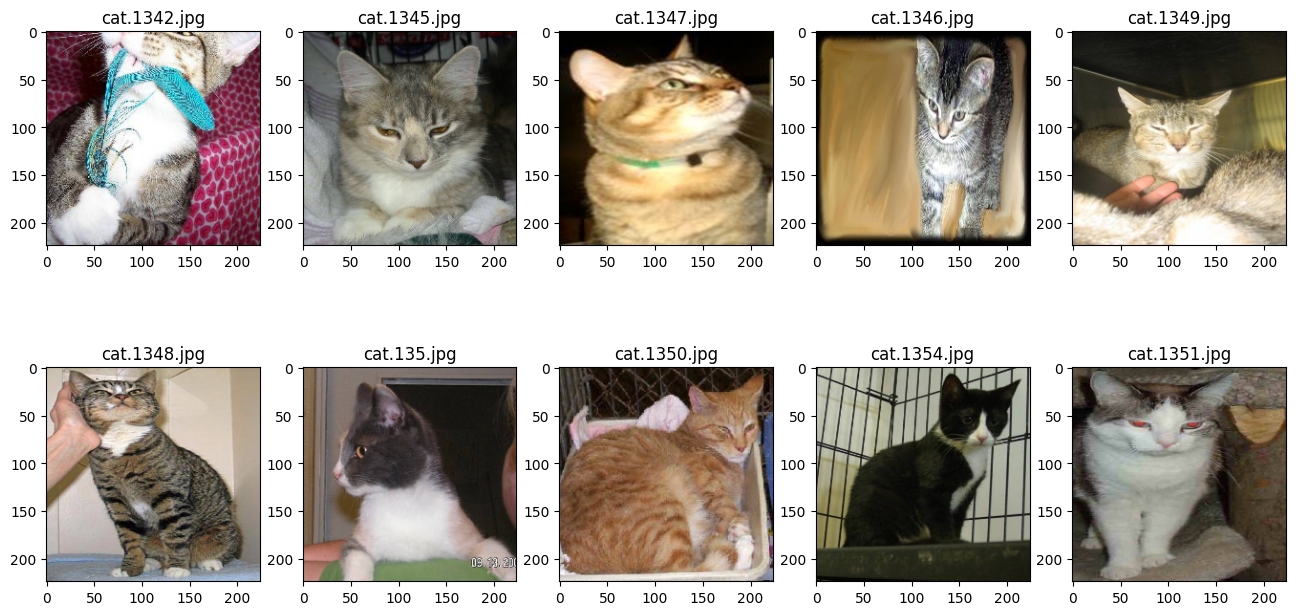

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загружаем предобученную модель

In [ ]:
base_model = mobilenet_v2.MobileNetV2(
            weights="imagenet",
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
            include_top=False,
            pooling="avg",
        )


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

## Добавляем полносвязный слой

In [ ]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации
                          )(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

## Выводим архитектуру модели

In [ ]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]'] 

## Компилируем модель и запускаем обучение

In [ ]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

In [ ]:
val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=12,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/12
10/10 [==============================] - 20s 2s/step - loss: 0.0548 - accuracy: 0.9781 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 2/12
10/10 [==============================] - 16s 2s/step - loss: 0.0573 - accuracy: 0.9812 - val_loss: 0.0158 - val_accuracy: 1.0000
Epoch 3/12
10/10 [==============================] - 16s 2s/step - loss: 0.0509 - accuracy: 0.9812 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 4/12
10/10 [==============================] - 16s 2s/step - loss: 0.0680 - accuracy: 0.9812 - val_loss: 0.0331 - val_accuracy: 1.0000
Epoch 5/12
10/10 [==============================] - 16s 2s/step - loss: 0.0326 - accuracy: 0.9906 - val_loss: 0.0294 - val_accuracy: 1.0000
Epoch 6/12
10/10 [==============================] - 16s 2s/step - loss: 0.0706 - accuracy: 0.9719 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 7/12
10/10 [==============================] - 16s 2s/step - loss: 0.0882 - accuracy: 0.9750 - val_loss: 0.0252 - val_accuracy: 1.0000
Epoch 8/12
10/10 [==

In [ ]:
model.save('/content/drive/MyDrive/Cats_Dogs/models/cats-dogs-mobilnet.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Предсказания на проверочной выборке

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 610s 49ms/step


In [ ]:
len(test_files)

12500

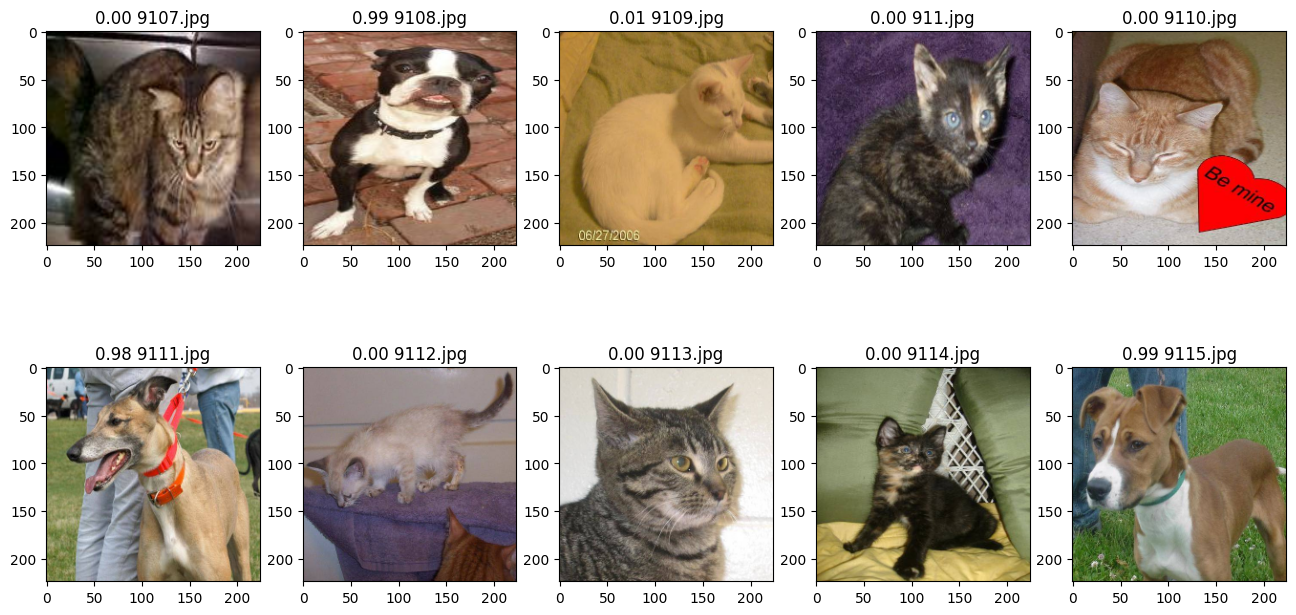

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[10:20], test_pred[10:20]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [ ]:
import re

with open('/content/drive/MyDrive/predictions/submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/predictions/submit.txt')

In [ ]:
df.head()

,id,label
0,9099,0.998189
1,91,0.002163
2,910,0.000620
3,9100,0.003219
4,9101,0.997305


In [ ]:
df.to_csv('/content/drive/MyDrive/predictions/submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f /content/drive/MyDrive/predictions/submission.csv -m "Message"

100% 171k/171k [00:00<00:00, 669kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition

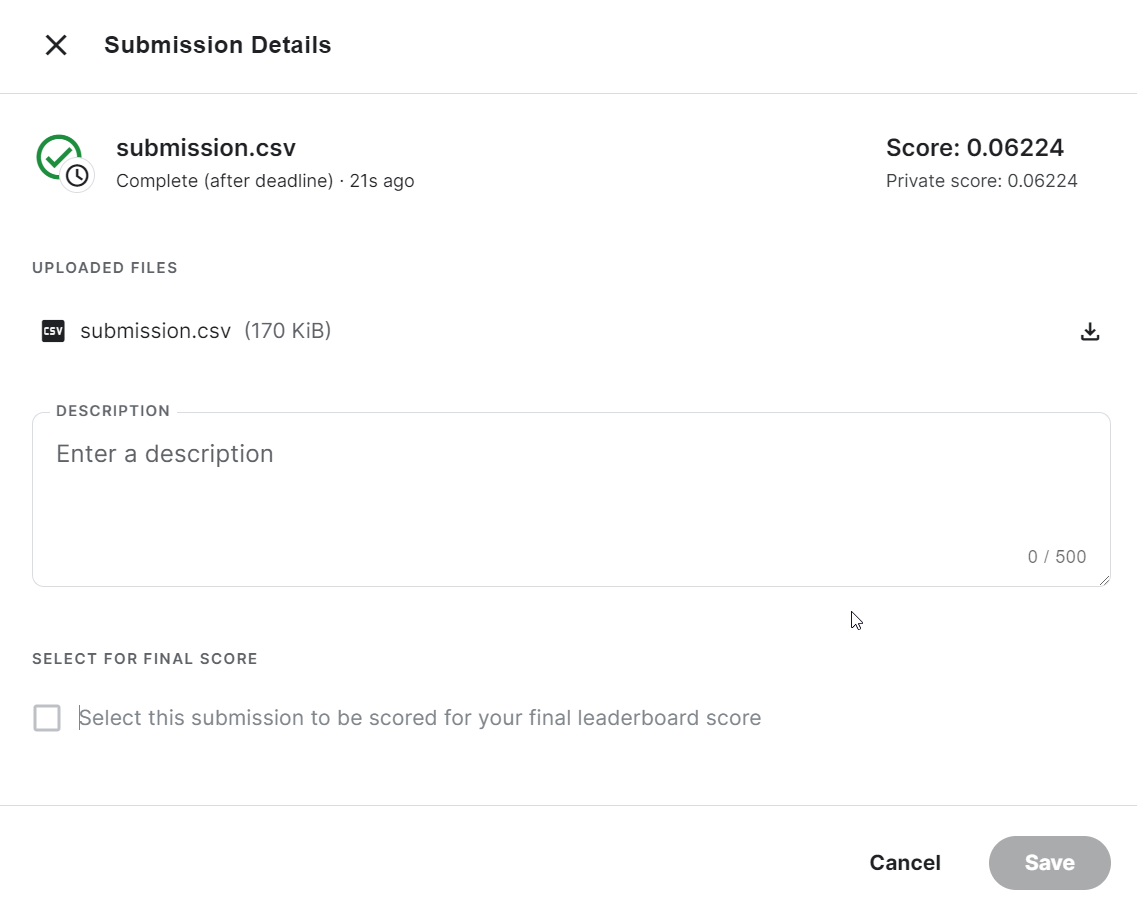